In [167]:
## import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

with open('result.json') as json_file:
    data = json.load(json_file)

In [138]:
## Function to calculate all metrics
## time is the time steps (integers) at which a note occurs
## notes are the note pitches (integers 0-127) where each note is "turned on" and "turned off"
## velocity is the note velocity (i.e. volume) at each time step
## measures is the number measures in the original piece
## min_note is the length of the shortest note in the original piece, using same scale as time array above
## num is the number of quarter notes in a measure (i.e. represents the numerator of time signature of the input piece)
## output is a vector of the calculated metrics:
##        entropy is the empirical entropy of new_notes
##        mutual_info is the mutual information between old_notes and new_notes
##        edit_dist is the edit distance between old_notes and new_notes
##        harmonic_ints is a vector of length 12 of the count of harmonic intervals of each type in new_notes
##        melodic_ints is a vector of length 12 of the count of melodic intervals of each type in new_notes
##        percentage is a vector of length 6 containing the percentage of perfect harmonic intervals, the percentage of imperfect 
##           consonant harmonic intervals, the percentage of dissonant harmonic intervals, the percentage of perfect melodic
##           intervals, the percentage of imperfect consonant melodic intervals and the percentage of dissonant melodic intervals      
##       note_counts is a vector of length equal to the number of unique pitches in old_notes with a normalized count of pitches
##           in new_notes
##       note_acf is a vector of length 41 with the acf of new_notes
##       note_pacf is a vector of length 41 with the pacf of new_notes
## Note: time is the same for old_notes and new_notes, as this is not changed between the original and generated pieces
##  (likewise, measures, min_note and num are the same for old_notes and new_notes)
def calc_metrics(time, old_notes, new_notes, velocity, measures, min_note, num):
    met_mat = create_matrix(time, new_notes, velocity, measures, min_note, num)
    harmonic_ints, m_ints, percentage = musical_metrics(met_mat)
    entropy, mutual_info, edit_dist, note_counts = originality_metrics_comparison(old_notes, new_notes)
    note_acf, note_pacf = time_metrics(new_notes)
    entropy = ent(new_notes)
    return(harmonic_ints, m_ints, percentage, entropy,note_acf, note_pacf)

In [170]:
data.keys()

dict_keys(['hmm10', 'hmm20', 'hmm30', 'lhmm10', 'lhmm20', 'dmm', 'bach', 'lstm', 'arhmm5'])

In [171]:
keys =['bach','dmm','lstm','hmm10', 'hmm20', 'hmm30', 'lhmm10', 'lhmm20', 'arhmm5']

### Originality Metric:
#### Entropy

In [172]:
#Entropy Comparison

entropy={}
for k in keys:
    ent_sum = 0
    for i in data[k]:
        ent_sum += i[3]
    ent_mean = ent_sum/len(data[k])
    entropy[k] = ent_mean
        

In [173]:
entropy

{'bach': 2.291468352958874,
 'dmm': 2.968552940950386,
 'lstm': 3.101727757793564,
 'hmm10': 3.2861974769966364,
 'hmm20': 3.3072802198546234,
 'hmm30': 3.3083488595435275,
 'lhmm10': 3.3104033170354192,
 'lhmm20': 3.3224639878421307,
 'arhmm5': 3.292978679632919}

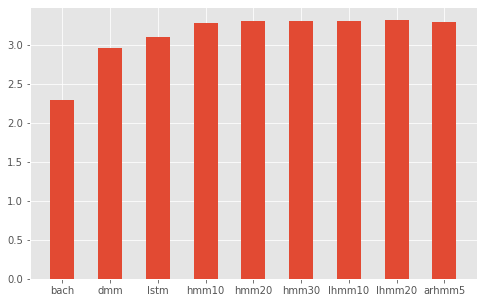

In [174]:
plt.figure(figsize=(8,5))

plt.bar(range(len(entropy)), list(entropy.values()), align='center',width=0.5)
plt.xticks(range(len(entropy)), list(entropy.keys()))

plt.show()


### Musicality Metrics:

#### The percentages of 
* perfect harmonic intervals
* imperfect consonant harmonic intervals
* dissonantharmonic intervals
* perfect melodic intervals
* imperfect consonantmelodic intervals
* dissonant melodic intervals. 

In [150]:
# percentage comparison 

percentage = {}
for k in keys:
    per_sum = 0
    for i in data[k]:
        per_sum += np.array(i[2])
        
    per_mean = per_sum/len(data[k])
    percentage[k] = per_mean

In [151]:
percentage

{'bach': array([0.23949572, 0.07614416, 0.68436012, 0.46322588, 0.220364  ,
        0.31641012]),
 'dmm': array([0.39020928, 0.53972474, 0.07006599, 0.36180418, 0.35984803,
        0.27834779]),
 'lstm': array([0.23478261, 0.33913043, 0.42608696, 0.34343434, 0.32034632,
        0.33621934]),
 'hmm10': array([0.15697178, 0.37719211, 0.46583611, 0.25164567, 0.33400833,
        0.414346  ]),
 'hmm20': array([0.15410191, 0.37500222, 0.47089587, 0.25241371, 0.33377301,
        0.41381328]),
 'hmm30': array([0.16923106, 0.35565577, 0.47511317, 0.25190252, 0.33246103,
        0.41563644]),
 'lhmm10': array([0.1854096 , 0.35475898, 0.45983141, 0.25240191, 0.33289601,
        0.41470208]),
 'lhmm20': array([0.14732158, 0.370851  , 0.48182742, 0.2525448 , 0.33360095,
        0.41385425]),
 'arhmm5': array([0.16010815, 0.37495436, 0.46493748, 0.25190481, 0.3339553 ,
        0.41413989])}

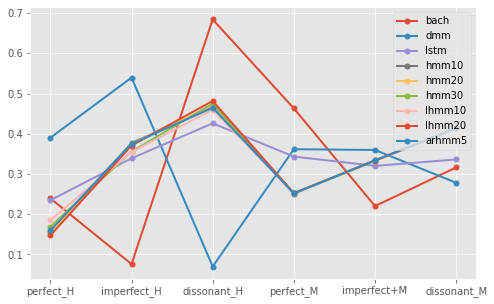

In [165]:
p = np.zeros([6,9])
#percentage[i]
for i in range(len(keys)):
    p[:,i] = percentage[keys[i]]
    
plt.figure(figsize=(8,5))
plt.plot(p, marker='o', linestyle='-',linewidth=2, markersize=5)

locs, labels = plt.xticks()
ax = ['perfect_H','imperfect_H','dissonant_H','perfect_M','imperfect+M','dissonant_M']
plt.xticks(np.arange(6), ax)

plt.legend(keys,loc='upper right')
plt.show()  



#### The number of 12 harmonic intervals 

In [155]:
#Harmonic Comparison

harmonic_ints={}
for k in keys:
    ent_sum = 0
    for i in data[k]:
        ent_sum += np.array(i[0])
    ent_mean = ent_sum/len(data[k])
    harmonic_ints[k] = ent_mean
    

In [156]:
harmonic_ints

{'bach': array([ 1.7, 16.9, 22. ,  1.9,  2.3,  8.8,  0.5,  4.6,  0.5,  0.1,  0.7,
         0.3]),
 'dmm': array([0.8, 0.2, 0.5, 2.9, 3.4, 2.5, 0.2, 2.5, 0.8, 0.7, 0.1, 0. ]),
 'lstm': array([12., 20., 53., 39., 23., 20., 12., 22.,  7.,  9., 11.,  2.]),
 'hmm10': array([ 3.5, 80.5, 80.4, 77.4, 60.8, 44.4, 25.7, 17.2,  8.3,  8.2,  2.9,
         1.6]),
 'hmm20': array([ 2.8, 81.7, 81.5, 78. , 59.4, 42.3, 22. , 17.3,  7.9,  5.4,  2.8,
         1.7]),
 'hmm30': array([ 1.1, 81.8, 82.4, 73.4, 61.3, 47.4, 24.5, 22.7,  9.1,  4. ,  6. ,
         2.5]),
 'lhmm10': array([ 5. , 81.6, 81.3, 77.7, 57. , 51.4, 23.1, 20.8,  7.7,  3.7,  1.9,
         1.4]),
 'lhmm20': array([ 1.4, 81.5, 80.3, 74.3, 59.4, 45.2, 29.1, 13.4, 11. ,  5.9,  3.4,
         0.7]),
 'arhmm5': array([ 2. , 81.6, 79.8, 74.6, 65.5, 47.7, 26.3, 17.2, 10.5,  5.3,  3.6,
         1.5])}

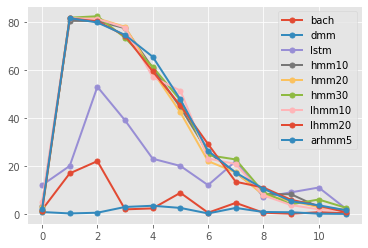

In [157]:
h = np.zeros([12,9])
#percentage[i]
for i in range(len(keys)):
    h[:,i] = harmonic_ints[keys[i]]
    
plt.figure()
plt.plot(h, marker='o', linestyle='-',linewidth=2, markersize=5)
plt.legend(keys)
plt.show()  

#### The number of 12 melodic intervals

In [158]:
#Melodic Comparison

m_ints={}
for k in keys:
    ent_sum = 0
    for i in data[k]:
        ent_sum += np.array(i[1])
    ent_mean = ent_sum/len(data[k])
    m_ints[k] = ent_mean
    

In [159]:
m_ints

{'bach': array([55.8, 26.6, 33.9, 23.2, 17.5, 28.7,  2.6, 15.5,  2.9,  2.6,  2.3,
         1.2]),
 'dmm': array([4. , 2.1, 3. , 3.5, 3.6, 4.2, 0.7, 4.4, 2.6, 2.9, 2.2, 1.8]),
 'lstm': array([99., 48., 75., 75., 60., 75., 42., 64., 36., 51., 46., 22.]),
 'hmm10': array([84. , 82.3, 82.8, 82.2, 82.9, 82.5, 80.7, 81.9, 82. , 82.6, 81.9,
        81.3]),
 'hmm20': array([84. , 82.3, 82.6, 82.7, 82.2, 82.5, 80.6, 82.6, 82.3, 82.2, 81.9,
        81. ]),
 'hmm30': array([84. , 82.8, 83. , 82.8, 82.6, 82.8, 81.4, 82.4, 81.3, 82.2, 82.5,
        81.5]),
 'lhmm10': array([84. , 82.3, 82.8, 83. , 82.3, 82.9, 81.6, 83. , 82.4, 81.9, 82. ,
        81.9]),
 'lhmm20': array([84. , 82.1, 81.8, 81.9, 82.5, 82.8, 81.1, 82.1, 82.5, 81.9, 81.7,
        81.2]),
 'arhmm5': array([84. , 82.2, 82.5, 82.7, 82.9, 82.7, 81.2, 82.6, 82.6, 82.3, 81.9,
        82.1])}

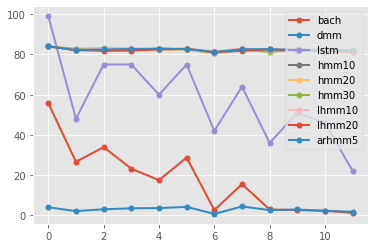

In [166]:
m = np.zeros([12,9])
#percentage[i]
for i in range(len(keys)):
    m[:,i] = m_ints[keys[i]]
    
plt.figure()
plt.plot(m, marker='o', linestyle='-',linewidth=2, markersize=5)
plt.legend(keys,loc='upper right')
plt.show()  

### Temporal Structures Metrics: 
#### Autocorrelation

In [161]:

note_acf={}
for k in keys:
    ent_sum = 0
    for i in data[k]:
        ent_sum += np.array(i[4])
    ent_mean = ent_sum/len(data[k])
    note_acf[k] = ent_mean
    

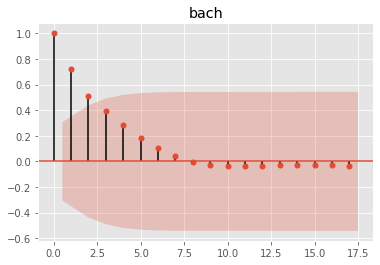

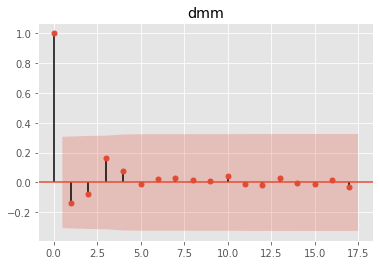

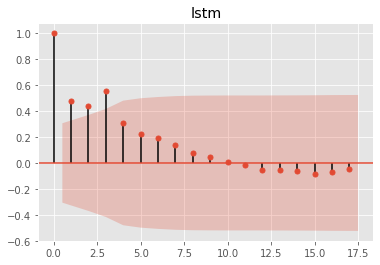

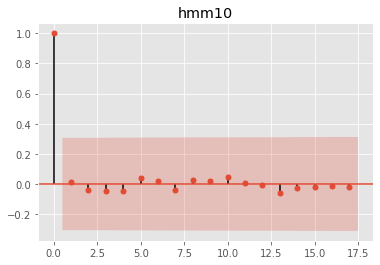

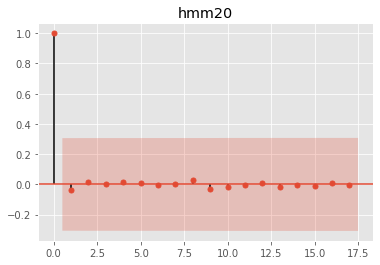

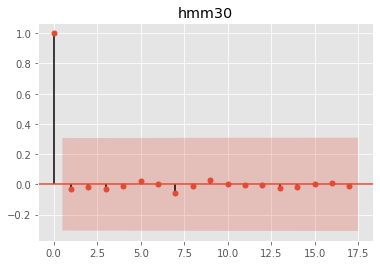

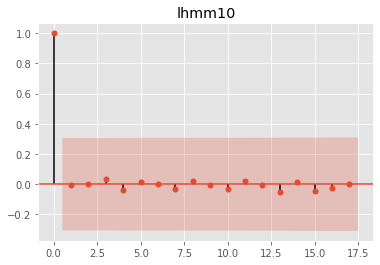

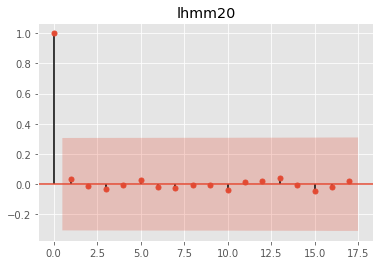

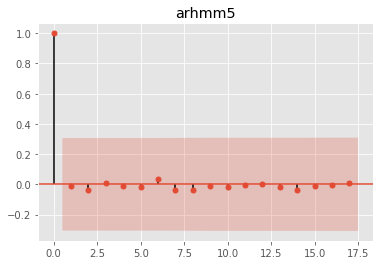

In [162]:
for k in note_acf.keys():
    plot_acf(note_acf[k])
    plt.title(k)

#### Partial Autocorrelation

In [163]:
note_pacf={}
for k in keys:
    ent_sum = 0
    for i in data[k]:
        ent_sum += np.array(i[5])
    ent_mean = ent_sum/len(data[k])
    note_pacf[k] = ent_mean

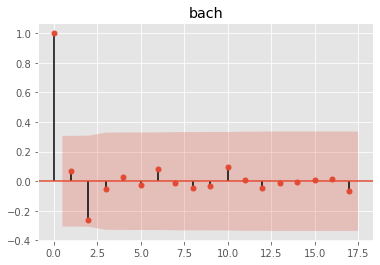

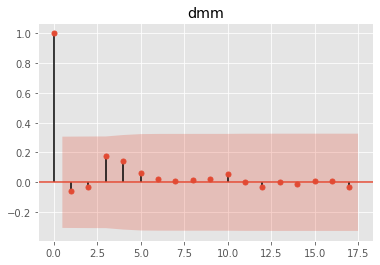

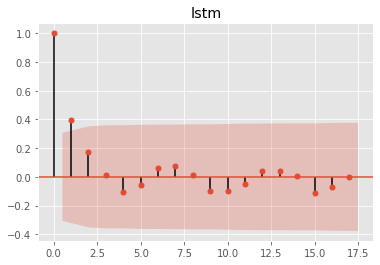

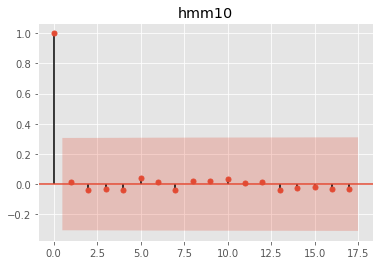

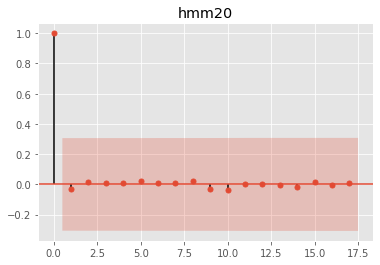

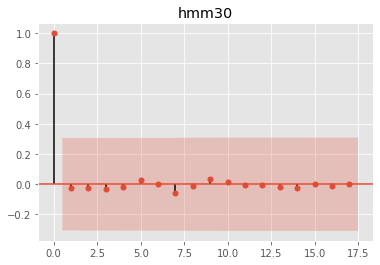

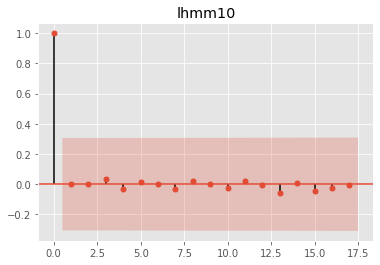

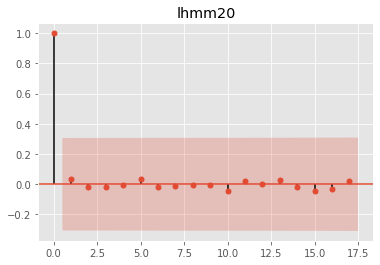

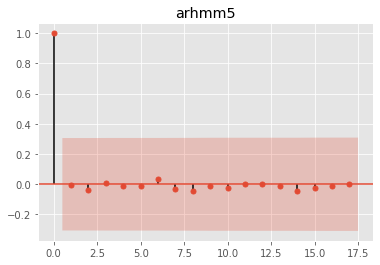

In [164]:
for k in note_acf.keys():
    plot_acf(note_pacf[k])
    plt.title(k)